#Session 1
## Explorative Analysis of EPEXPOT Prices

The first step in the data mining process is to develop an understanding of the business as well as the data that is needed to support it (see CRISP-DM). The next step in the process is data preparation, wich requires is to first akquire the data. Nowadays plenty of data is available on the web, either through APIs (Twitter, Goolgle, Quandl, etc.) or on the web pages themselves. If data is somehow embedded on a website, we need to go through a process called scraping, in order to separate the required data from the rest of the content. 

### Scraping EPEXSPOT Prices

Let us assume that we need hourly electricity prices from the EPEXSPOT market for our business case. EPEXSPOT sells this data, but it must also provide the data on its website, for example, data for the [current week](https://www.epexspot.com/en/market-data/dayaheadauction/auction-table). 

#### BeautifulSoup

To akquire the content and weed out the needed prices, we are going to use a Python library called [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

In [1]:
from bs4 import BeautifulSoup
import urllib

If we provide the day of the week in the ULR, we get one week of hourly prices, with the given date as the last day of the week. We can use this in a later step to build a fully automated mining bot. By providing BeautifulSoup with the content of the url, it can import and store the content in a proprietary format.

In [2]:
url = urllib.urlopen('https://www.epexspot.com/en/market-data/dayaheadauction/auction-table/2016-10-05/de')
url = url.read()
soup = BeautifulSoup(url,"lxml")

All price data is available in a table with a *table* tag and has *list hours responsive* as its class name. We can therefore tell BeautifulSoup to extract content that meets this specification from the website and store it for us. BeautifulSoup stores all content that meets this requirement as a *ResultSet* and the individual elements in the set as *Tag*.

In [3]:
table = soup.find_all('table', class_='list hours responsive')
print type(table), type(table[1])

<class 'bs4.element.ResultSet'> <class 'bs4.element.Tag'>


The result set contains three tables, each holding one week of hourly prices for different markets. The Autrian-German prices are in table 1. The string representation of the Tag that holds table 1 returns its HTML code. Let us take a look at the first 1000 characters and check if the prices shows in the *td* tags match the prices from the website.

In [4]:
str(table[1])[:1000]

'<table border="0" cellpadding="0" cellspacing="0" class="list hours responsive" width="100%">\n<tbody>\n<tr>\n<th class="title"></th>\n<th class="units"></th>\n<th>Thu, 29/09</th>\n<th>Fri, 30/09</th>\n<th>Sat, 01/10</th>\n<th>Sun, 02/10</th>\n<th>Mon, 03/10</th>\n<th>Tue, 04/10</th>\n<th>Wed, 05/10</th>\n</tr>\n<tr class="no-border">\n<td class="title">\n                                                                    00 - 01\n                                                            </td>\n<td>\xe2\x82\xac/MWh</td>\n<td>19.93</td>\n<td>23.79</td>\n<td>29.18</td>\n<td>32.68</td>\n<td>30.81</td>\n<td>25.96</td>\n<td>25.06</td>\n</tr>\n<tr>\n<td>\xc2\xa0</td>\n<td>MWh</td>\n<td>27,661.0</td>\n<td>30,611.2</td>\n<td>21,479.9</td>\n<td>27,717.4</td>\n<td>25,759.7</td>\n<td>27,026.6</td>\n<td>29,045.6</td>\n</tr>\n<tr class="no-border">\n<td class="title">\n                                                                    01 - 02\n                                                   

#### Pandas
To be able to analyze the price data, we must convert the data from html format into some data structure that does not treat the prices as strings but as floating point numbers, which will then allow us to perform numerical analyses. A popular library for data analysis in Python is [Pandas](http://pandas.pydata.org). 

In [5]:
import pandas as pd

Since Pandas understands html content, we are going to use the builder function *read_html()* which returns a Pandas *DataFrame*. The DataFrame is Pandas' most popular and powerful data structure, and we will revisit this class throughout this course.

In [6]:
df = pd.read_html(str(table[1]), header=0, encoding='utf8')[0]
df.head()

,Unnamed: 0,Unnamed: 1,"Thu, 29/09","Fri, 30/09","Sat, 01/10","Sun, 02/10","Mon, 03/10","Tue, 04/10","Wed, 05/10"
0,00 - 01,€/MWh,19.93,23.79,29.18,32.68,30.81,25.96,25.06
1,NaN,MWh,27661.00,30611.20,21479.90,27717.40,25759.70,27026.60,29045.60
2,01 - 02,€/MWh,16.10,23.32,31.06,27.04,26.11,25.28,23.67
3,NaN,MWh,27477.10,30416.60,22158.90,27815.30,26441.40,27752.50,27997.60
4,02 - 03,€/MWh,18.63,23.81,26.00,26.28,25.09,24.05,22.45


### Data Preparation
As soon as our data is available as a Pandas *DataFrame*, we can begin with the next step in our data mining process  clearning, transforming, merging and reshaping the data.

The table currently holds prices and volumes for each hour in rows and for each week in columns. Since we do not need the row labels for the hours and the volumns, we are going to drop these columns.

In [7]:
df = df.drop(['Unnamed: 0','Unnamed: 1'],axis=1)
df.head()

,"Thu, 29/09","Fri, 30/09","Sat, 01/10","Sun, 02/10","Mon, 03/10","Tue, 04/10","Wed, 05/10"
0,19.93,23.79,29.18,32.68,30.81,25.96,25.06
1,27661.00,30611.20,21479.90,27717.40,25759.70,27026.60,29045.60
2,16.10,23.32,31.06,27.04,26.11,25.28,23.67
3,27477.10,30416.60,22158.90,27815.30,26441.40,27752.50,27997.60
4,18.63,23.81,26.00,26.28,25.09,24.05,22.45


Afterwards, we must separate the prices from the volumes. This is fairly easy, since every row with an even number holds prices and every row with an odd number the volumes. All iterable objects in Python, like lists, Numpy arrays, or Pandas DataFrames understand some powerful but sytactically easy-to-use indexing statements. For example, to get all even rows, we simple need to call:

In [8]:
df[::2].head()

,"Thu, 29/09","Fri, 30/09","Sat, 01/10","Sun, 02/10","Mon, 03/10","Tue, 04/10","Wed, 05/10"
0,19.93,23.79,29.18,32.68,30.81,25.96,25.06
2,16.10,23.32,31.06,27.04,26.11,25.28,23.67
4,18.63,23.81,26.00,26.28,25.09,24.05,22.45
6,14.57,23.09,29.02,25.13,24.54,22.03,22.23
8,14.15,24.02,25.94,24.90,24.59,23.25,22.71


The iterator loops over all rows, but increments the index in increments of two, so that we only get to see rows with an even number. The function *head()* finally shows us the first five rows of the resulting copy of the DataFrame.

The next step is to flatten the resulting table, so that all columns of the table are stacked on top of each other, and all 7 x 24 prices are returned as a single long array. Before we can stack the columns, we must transpose the table, since the function *stack()* works row-wise and not column-wise. The function *tranpose()* simply flips the indices internally, which corresponds to the mathematical concept of transposing a matrix.

In [9]:
prices = df[::2].transpose().stack()

Although the dates are provided in the columns, they are not in a good format to be parsed as dates. Since we know the last day of the week, however, we can create our own time index, by using the Pandas builder function *date_range()*. We then replace the existing index with the new datetime index.

In [10]:
index = pd.date_range(end='2016-10-05-23:00', periods=7*24, freq='h')
prices = df[::2].transpose().stack()
prices.index = index

Note that the last element of the date time index is defined to as 23:00. If we do not specify the last hour, the index would have started at 1:00 and not at 0:00. Since prices are valid for a whole hour, in this case going from 0:00 to 1:00, it is really a matter of definition, whether we set the axis tick at 0:00 or 1:00, but it is more natural to pick the beginning of an hour as the tick.

To finally plot the result we can now use the function *plot()* which will return a line chart with the time series of hourly prices. We can see that, by providing a datetime index, the x-axis automatically gets properly formated with the correct dates.

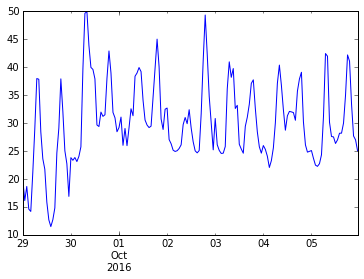

In [11]:
prices.plot()

Now we can do the same with the volumes. This time we need all odd rows, so the index has to start at 1. The datetime index for volumes and prices is the same, so that we can replace the volumes index with our previously created datetime index.

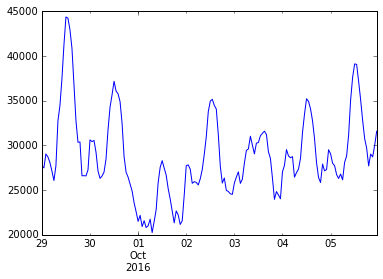

In [12]:
volumes = df[1::2].transpose().stack()
volumes.index = index
volumes.plot()

The above data is not stored as a DataFrame but as a *Series* which, in contrast to DataFrame, is one-dimensional. Since Series cannot be extended, we must first create a new empty DataFrame with our datetime index as its index. Then we append prices and volumes to the newsly created DataFrame and call *head()* to look at the first firve rows.

In [13]:
df = pd.DataFrame(columns=['prices'])
df['prices'] = prices
df['volumes'] = volumes
df.head()

,prices,volumes
2016-09-29 00:00:00,19.93,27661.0
2016-09-29 01:00:00,16.10,27477.1
2016-09-29 02:00:00,18.63,29033.6
2016-09-29 03:00:00,14.57,28702.6
2016-09-29 04:00:00,14.15,28080.6


Now that our data is in the right format and shape, we can begin with our exploratory analyses.

## Exercises
1. Manually collect data from the entire month of September. Use pd.concat() to merge all dataframes together into a single one. The easiest approach is to create a list at the very top to which you append the new dataframes and then insert this list into concat() function. Optional: Use a loop to automatically loop over the past couple of weeks.
2. What is the peak price (9:00 to 20:00) for each day? What is the base price (daily mean)? Plot both prices in a single plot.
3. Is there a relationship between price and volume? What is a good way to measure this relationship? What would be a good way to visualize it?
4. Plot the distribution of hourly prices in one graph.
5. Plot the time series of weekly averages

### 1) Price-volume relationship (example)
A commonly used way to visualize the relationship of two variables is the scatter plot. Here prices are the x-ccordinates and volumes the y-coordinates.

In [3]:
df.plot(kind='scatter', x='prices', y='volumes')

NameError: name 'df' is not defined